# Spam classifier

**Objective:** build a spam classifier with at least 99% precision and at least 90% recall.

**Data:** 1897 spam emails + 4150 non-spam emails (181 non-english emails will be removed)

**Methodology:** train Naive Bayes classification model using TF-IDF vectorized email texts to learn whether an email is spam or non-spam with at least 99% precision and 90% recall.

In [1]:
import os
import numpy as np
import pandas as pd

from utils import fetch_data, load_email, make_email_example, plot_precision_recall_vs_threshold

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve

import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
from langdetect import DetectorFactory

from tqdm.notebook import tqdm

pd.set_option('max_colwidth', 100)
tqdm.pandas()

## Download email corpus

Download and extract some genuine emails and spams from the SpamAssassin public email corpus.

Source: https://spamassassin.apache.org/old/publiccorpus/

In [2]:
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
SPAM_PATH = os.path.join("datasets", "spam")

fetch_data(DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_easy_ham_2.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_hard_ham.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_spam.tar.bz2", SPAM_PATH)
fetch_data(DOWNLOAD_ROOT + "20030228_spam_2.tar.bz2", SPAM_PATH)

## Import raw emails

Parse the raw email files we just downloaded.

In [3]:

easy_ham_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'easy_ham')) if name != 'cmds']
easy_ham_2_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'easy_ham_2')) if name != 'cmds']
hard_ham_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'hard_ham')) if name != 'cmds']
spam_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'spam')) if name != 'cmds']
spam_2_filenames = [name for name in os.listdir(os.path.join(SPAM_PATH, 'spam_2')) if name != 'cmds']

easy_ham_emails = [load_email(os.path.join(SPAM_PATH, 'easy_ham'), name) for name in easy_ham_filenames]
easy_ham_2_emails = [load_email(os.path.join(SPAM_PATH, 'easy_ham_2'), name) for name in easy_ham_2_filenames]
hard_ham_emails = [load_email(os.path.join(SPAM_PATH, 'hard_ham'), name) for name in hard_ham_filenames]
spam_emails = [load_email(os.path.join(SPAM_PATH, 'spam'), name) for name in spam_filenames]
spam_2_emails = [load_email(os.path.join(SPAM_PATH, 'spam_2'), name) for name in spam_2_filenames]


## Create labelled examples

Scrape the text from the emails and add it to an 1x2 array with the label (1=spam, 0=no spam).

In [4]:
%%time

examples = np.empty((0,2), 'object')
for i, he in enumerate(easy_ham_emails + easy_ham_2_emails + hard_ham_emails):
    try:
        examples = np.append(examples, make_email_example(he, is_spam=False, clean=True), axis=0)
    except:
        print(i)
for i, se in enumerate(spam_emails + spam_2_emails):
    try:
        examples = np.append(examples, make_email_example(se, is_spam=True, clean=True), axis=0)
    except:
        print(i)

df = pd.DataFrame(examples, columns = ['Text', 'Spam'])
df.head()

CPU times: total: 51 s
Wall time: 51.2 s


,Text,Spam
0,"re: new sequences window date: wed, 21 aug 2002 10:54:46 -0500 from: chris garrigues message-id:...",0
1,"re: alexander martin a posted: tassos papadopoulos, the greek sculptor behind the plan, judged t...",0
2,"moscow bomber man threatens explosion in moscow thursday august 22, 2002 1:40 pm moscow (ap) - s...",0
3,klez: the virus that won't die klez: the virus that won't die already the most prolific virus ev...,0
4,"re: nothing like mama used to make in adding cream to spaghetti carbonara, which has the same ef...",0


## Text preprocessing

Lemmatize and detect langugage with confidence score, then remove non-English emails or English emails with confidence less than 0.99

In [5]:
# Since SpaCy 3.0 to add custom factory component to Spacy pipeline:
# 1. create function with arguments nlp and name that returns a factory
# 2. decorate function with @Language.factory('foo')
@Language.factory('language_detector')
def get_lang_detector(nlp, name):
    # https://github.com/Abhijit-2592/spacy-langdetect/issues/3
    DetectorFactory.seed = 42
    return LanguageDetector()

In [27]:
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('parser', 'ner')
nlp.add_pipe('sentencizer')
nlp.add_pipe('language_detector')
print("Spacy pipeline:", " > ".join(nlp.pipe_names))

def email_nlp_preproc(text):
    doc = nlp(text)
    lem = " ".join([token.lemma_ for token in doc])
    lang, conf = doc._.language.values()
    return lem, lang, conf

Spacy pipeline: tok2vec > tagger > attribute_ruler > lemmatizer > sentencizer > language_detector


In [28]:
df[['Text_Lemm', 'Lang', 'Conf']]  = pd.DataFrame(
    df['Text'].progress_apply(email_nlp_preproc).tolist()
    )

  0%|          | 0/6047 [00:00<?, ?it/s]

In [35]:
s = df[df.Lang == 'en'][['Text_Lemm', 'Lang', 'Conf']].sort_values('Conf').sample(5).style
s.set_table_styles({
   ('Text_Lemm'): [{'selector': 'td', 'props': 'max-width: 800px; overflow: hidden; text-overflow: ellipsis; white-space: nowrap;'},
              {'selector': 'td:hover', 'props': 'overflow: visible; white-space: normal;'}]
}, overwrite=False)
print("Here's some examples.\nHover on the text to see the full content.")
s

Here's some examples.
Hover on the text to see the full content.


,Text_Lemm,Lang,Conf
1145,"unseen window versus sequence window I apologize for not catch up to the current code in so long . now that I have I be try to resolve "" breakage "" and difference . the unseen window seem to have be replace with the sequence window . while I appreciate the flexibility of the sequence window , the unseen window fill an important - to - I need : it be tiny and could be set to show on all desktop of a virtual window manager without take a lot of space . since my normal mode of operation involve two copy of exmh display on a 1024x768 vnc session , screen space be at a premium . as thing stand now , I have a sequence window that show a lot more information than I need to have handy and take up a lot more room than I can "" spare "" . I can see that I could like the new sequence window a lot for certain operation . but I would like a nice uncluttered , tiny window that _ only _ show I info on my unread mail . one possibility that occur to I would be a button or mouse click that "" shrink "" the sequence window to show only the sequence in the "" always show "" list . and of course a way to expand it back . hal exmh - worker mailing list",en,0.999998
1489,"re : phew ! matt kettler say : ok , first , the important stuff . happy birthday justin ( a lil late , but oh well ) cheer ! a 13 % miss ratio on the spam corpus at 5.0 seem awfully high , although that nice low fp percentage be quite nice , as be the narrow - in of average fp / fn score compare to 2.40 . as dan say it be a hard corpus , make hard without the spamtrap datum . also and this be an important point those measurement can not be directly compare , because I change the methodology . in 2.40 the score be evolve on the entire corpus , then evaluate use that corpus ; ie . there be no "" blind "" testing , and the score could overfit and still provide good statistic . in 2.42 , they be evaluate "" blind "" , on a totally unseen set of message , so those figure would be a lot more accurate for real - world use . j.",en,0.999998
823,"re : ebusiness webform : cluetrain have leave the station ... webform /can/ accept "" u.s . of a "" as a country . incredible , but true . web form can also accept /multiple/ or even /free - form/ telephone number ... be the people who use procrustean web form practice the same one who do not accept fax ? when I * really * need to get something do , instead of just idle surfing , I call or fax . faxing , like a web form , can be do 24x7 ; it allow I to give all the ( and only the ) pertinent info in a single place ; it also provide a self - journalle correspondence , which mean rollback be easy and replay be even easy . -dave sure , tile window be the good we have for a brief period of time , but they be completely useless except for some terminal base replacement application . I 've be run a tiled ( but somewhat overlap , yield a horizontal stack ) window manager lately . like fill in a web form , find edge and shuffle window may seem productive , but I find that have a window manager manage the window mean I can concentrate on what I want to do with their content . "" dumb question : x client behind a firewall ? "" back in my day , they do not have ssh . then again , back in my day , they do not have firewall . back in my day , when one change computer installation , email would be forward as a courtesy . now , we seem to have swing so far in the opposite direction that it make sense to ditch address every couple of year to shed spam .",en,0.999997
1656,"deployment I think one step towards deployment be create a re - usable tokenizer for mail message . the current codebase do not expose an easy - to - use or easy - to - customize tokenizer . the timtest module seem to contain an enormous body of practical knowledge about how to parse mail message , but the module be not design for re - use . I would like to see a module that can take a single message or a collection of message and tokenize each one . I would like to s

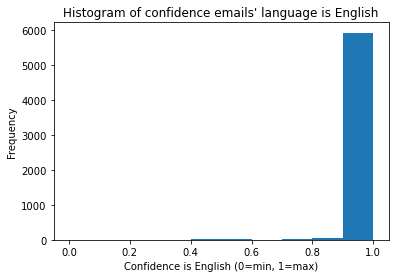

In [36]:
ax = df['Conf'].plot(kind='hist', title="Histogram of confidence emails' language is English")
_ = ax.set_xlabel("Confidence is English (0=min, 1=max)")

In [37]:
df_en = df[(df.Lang == 'en') & (df.Conf >= 0.99)]
print('Non-english emails removed:', len(df) - len(df_en))

Non-english emails removed: 181


## Training

Build the following pipeline and use it in a standard Grid Search CV to find the best hyperparameters the second and third stages of the pipeline.

**Pipeline:**
Lemmatizer > TF-IDF vectorizer > Naive Bayes classifier


In [38]:
X = df_en['Text_Lemm'].copy()
y = df_en['Spam'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
%%time

full_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB())
])

param_grid = [
    {
        'tfidf__stop_words': ['english'],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'tfidf__max_df': [20, 50],
        'tfidf__min_df': [1, 10],
        'model__alpha': [.1, 1]
    }
]

kfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(full_pipeline, param_grid, cv=kfolds,
                           scoring=['accuracy', 'f1_weighted'], refit='accuracy', verbose=3)
                           
_ = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; accuracy: (test=0.930) f1_weighted: (test=0.928) total time=   2.5s
[CV 2/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; accuracy: (test=0.939) f1_weighted: (test=0.938) total time=   2.7s
[CV 3/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__stop_words=english; accuracy: (test=0.932) f1_weighted: (test=0.930) total time=   2.5s
[CV 1/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__stop_words=english; accuracy: (test=0.974) f1_weighted: (test=0.974) total time=   5.6s
[CV 2/3] END model__alpha=0.1, tfidf__max_df=20, tfidf__min_df=1, tfidf__ngram_range=(1, 2), tfidf__stop_words=english; accuracy: (test=0.974) f1_weighted: (test=0.974) total time=   5.9s

## Customize best model

Since this is a spam classifier it makes sense to maximize precision while worsening  recall.

In [40]:
y_proba = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=kfolds,
                            method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_proba[:, 1])

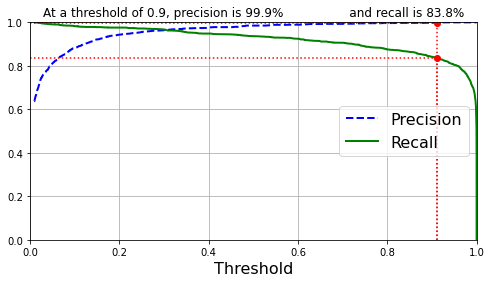

In [41]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, cond=np.argmax(precisions >= .999))

## Test

Final metrics on unseen data.

In [42]:
custom_thr = thresholds[np.argmax(precisions >= .99)]
y_hat = grid_search.best_estimator_.predict_proba(X_test)[:,1] >= custom_thr

print(f"Accuracy: {accuracy_score(y_test, y_hat):.2%}")
print(f"Precision: {precision_score(y_test, y_hat):.2%}")
print(f"Recall: {recall_score(y_test, y_hat):.2%}")

Accuracy: 97.53%
Precision: 100.00%
Recall: 91.94%
